In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import networkx as nx
from bs4 import BeautifulSoup
import re

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from collections import Counter


from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

from base64 import urlsafe_b64decode#, urlsafe_b64encode

SCOPES = ['https://mail.google.com/']
our_email = 'patrykstatkiewicz1012@gmail.com'

In [ ]:
def gmail_authenticate():
    """
    taking authentication token with allowance of gmail and save authentication token to pickle file for not future asking,
    if there is pickle file with token jest take it from there
    """
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)
    return build('gmail', 'v1', credentials=creds)

service = gmail_authenticate()

In [ ]:
def fetch_messages(service, query):
    """
    getting access to messages in e-mail account
    """
    result = service.users().messages().list(userId='me', q=query).execute()
    messages = []
    if 'messages' in result:
        messages.extend(result['messages'])
    while 'nextPageToken' in result:
        page_token = result['nextPageToken']
        result = service.users().messages().list(userId='me', q=query, pageToken=page_token).execute()
        if 'messages' in result:
            messages.extend(result['messages'])
    return messages

def search_messages(service, query_inbox="in:inbox", query_sent="in:sent", date_after=None, date_before=None):
    """
    devide e-mails for sent and received
    """
    date_query = ""
    if date_after:
        date_query += f" after:{date_after.strftime('%Y/%m/%d')}"
    if date_before:
        date_query += f" before:{date_before.strftime('%Y/%m/%d')}"
    
    query_inbox = f"{query_inbox}{date_query}"
    query_sent = f"{query_sent}{date_query}"
    inbox_messages = fetch_messages(service, query_inbox)
    sent_messages = fetch_messages(service, query_sent)

    return inbox_messages, sent_messages

def get_headers_from_message(service, message_id):
    """
    getting information from e-mail about date, receiver, sender and subject
    """
    message = service.users().messages().get(userId='me', id=message_id, format='full').execute()
    headers = message['payload']['headers']
    
    message_data = {
        'Message_ID': message_id,
        'Date': None,
        'From': None,
        'To': None,
        'Subject': None
    }
    
    for header in headers:
        if header['name'] == 'Date':
            message_data['Date'] = header['value']
        elif header['name'] == 'From':
            message_data['From'] = header['value']
        elif header['name'] == 'To':
            message_data['To'] = header['value']
        elif header['name'] == 'Subject':
            message_data['Subject'] = header['value']
    
    return message_data

def create_dataframe_from_messages(service, messages):
    """
    creating pandas data frame from messages
    """
    message_data_list = []
    
    for message in messages:
        message_id = message['id']
        message_data = get_headers_from_message(service, message_id)
        message_data_list.append(message_data)
    
    df = pd.DataFrame(message_data_list)
    return df

def fix_dates(df):
    """
    changing dates to achieve format that can be changed to datetime object
    """
    dates = []
    for i in range(len(df)):
        j = 0
        l = 0
        k = ''
        text = df['Date'][i]
        for char in text:
            if l == 1:
                if char == ' ':
                    dates.append(df['Date'][i][j-1:j+18])#9
                    l = 0
                    k = 'STOP'
                    pass
            if char.isdigit() == True:
                l += 1
                if l == 2:
                    if k != 'STOP':
                        dates.append(df['Date'][i][j-1:j+19])#10
                        pass            
            j += 1
    return dates

def fix_mails(df, column):
    """
    change string to obtain only e-mail addresses
    """
    mail = []
    for i in range(len(df)):
        text = df[column][i]
        j = 0
        l = 0
        p = 0
        for char in text:
            if char == '<':
                l = 1
                for k in text[j:]:
                    p += 1
                    if k == '>':
                        mail.append(text[j+1:j+p-1])      
            j += 1
        if l == 0:
            mail.append(text)
    return mail

In [4]:
date_after = None
date_before = None

inbox_messages, sent_messages = search_messages(service)
print(f"Number of received mails: {len(inbox_messages)}")
print(f"Number of sent mails: {len(sent_messages)}")

Number of received mails: 13583
Number of sent mails: 115


In [5]:
df_sent = create_dataframe_from_messages(service, sent_messages)
df_sent

,Message_ID,Date,From,To,Subject
0,1922af1ccfc0be12,"Wed, 25 Sep 2024 20:49:02 +0000",Patryk Statkiewicz <patrykstatkiewicz1012@gmai...,astatkiewicz@ognik-bis.pl,
1,191b85e1515615da,"Tue, 3 Sep 2024 16:50:59 +0200",Patryk Statkiewicz <patrykstatkiewicz1012@gmai...,gjw0314mrx70p6@print.epsonconnect.com,1
2,191b84896a0bcdd2,"Tue, 3 Sep 2024 16:27:31 +0200",Patryk Statkiewicz <patrykstatkiewicz1012@gmai...,gjw0314mrx70p6@print.epsonconnect.com,1
3,191b840945f28d35,"Tue, 3 Sep 2024 16:18:47 +0200",Patryk Statkiewicz <patrykstatkiewicz1012@gmai...,gjw0314mrx70p6@print.epsonconnect.com,
4,1910aa6976b40a77,"Wed, 31 Jul 2024 23:16:15 +0200",Patryk Statkiewicz <patrykstatkiewicz1012@gmai...,Informacoes Gerais Correio <informacoes.gerais...,Re: SR0020748272: Site CTT - Formulário de Con...
...,...,...,...,...,...
110,1590795f8bf8d1cb,"Fri, 16 Dec 2016 13:23:06 +0100",Patryk Statkiewicz <patrykstatkiewicz1012@gmai...,Gitara Siema <meksykanskilamaczserc@gmail.com>,Re: Masz
111,1590455cb031542b,"Thu, 15 Dec 2016 22:14:08 +0100",Patryk Statkiewicz <patrykstatkiewicz1012@gmai...,meksykanskilamaczserc@gmail.com,A no spoko
112,15903b5e57ae7452,"Thu, 15 Dec 2016 19:19:29 +0100",Patryk Statkiewicz <patrykstatkiewicz1012@gmai...,meksykanskilamaczserc@gmail.com,Masz
113,1582f792b8ba5a77,"Fri, 4 Nov 2016 14:13:39 +0100",Patryk Statkiewicz <patrykstatkiewicz1012@gmai...,rogogon188@gmail.com,Radek Koczan Dubieniecki


In [6]:
dates = fix_dates(df_sent)
to = fix_mails(df_sent, 'To')
from_ = fix_mails(df_sent, 'From')
df_sent['To'] = to
df_sent['From'] = from_
df_sent['Date'] = dates
df_sent

,Message_ID,Date,From,To,Subject
0,1922af1ccfc0be12,25 Sep 2024 20:49:02,patrykstatkiewicz1012@gmail.com,astatkiewicz@ognik-bis.pl,
1,191b85e1515615da,3 Sep 2024 16:50:59,patrykstatkiewicz1012@gmail.com,gjw0314mrx70p6@print.epsonconnect.com,1
2,191b84896a0bcdd2,3 Sep 2024 16:27:31,patrykstatkiewicz1012@gmail.com,gjw0314mrx70p6@print.epsonconnect.com,1
3,191b840945f28d35,3 Sep 2024 16:18:47,patrykstatkiewicz1012@gmail.com,gjw0314mrx70p6@print.epsonconnect.com,
4,1910aa6976b40a77,31 Jul 2024 23:16:15,patrykstatkiewicz1012@gmail.com,informacoes.gerais@ctt.pt,Re: SR0020748272: Site CTT - Formulário de Con...
...,...,...,...,...,...
110,1590795f8bf8d1cb,16 Dec 2016 13:23:06,patrykstatkiewicz1012@gmail.com,meksykanskilamaczserc@gmail.com,Re: Masz
111,1590455cb031542b,15 Dec 2016 22:14:08,patrykstatkiewicz1012@gmail.com,meksykanskilamaczserc@gmail.com,A no spoko
112,15903b5e57ae7452,15 Dec 2016 19:19:29,patrykstatkiewicz1012@gmail.com,meksykanskilamaczserc@gmail.com,Masz
113,1582f792b8ba5a77,4 Nov 2016 14:13:39,patrykstatkiewicz1012@gmail.com,rogogon188@gmail.com,Radek Koczan Dubieniecki


In [7]:
df_inbox = create_dataframe_from_messages(service, inbox_messages)
df_inbox

,Message_ID,Date,From,To,Subject
0,193406ca953ee72e,"Mon, 18 Nov 2024 09:58:02 -0800",PayPal <service@paypal.pl>,Patryk Statkiewicz <patrykstatkiewicz1012@gmai...,Potwierdzenie Twojej płatności na rzecz firmy ...
1,193404e3cdea8fda,"Mon, 18 Nov 2024 11:21:20 -0600","""Tom Clancy's Rainbow Six Siege"" <news@updates...",<patrykstatkiewicz1012@gmail.com>,💥 Year 9 comes to a close with a bang
2,1933efbafb0554d4,"Mon, 18 Nov 2024 11:11:25 GMT","""eobuwie.pl"" <info@eobuwie.pl>",patrykstatkiewicz1012@gmail.com,50 zł na kolejne zakupy! 🎉
3,1933ef36bf198405,"Mon, 18 Nov 2024 11:06:00 +0000","""Infopiguła"" <newsletter@infopigula.pl>",patrykstatkiewicz1012@gmail.com,[Infopiguła - newsletter] Newsletter - wydanie...
4,1933e9b138830ea3,"Mon, 18 Nov 2024 08:13:03 +0000",Eneba <info@eneba.deals>,patrykstatkiewicz1012@gmail.com,📢 Black Friday deals marathon! 🤑
...,...,...,...,...,...
13578,156c20a62b75692b,"Thu, 25 Aug 2016 14:11:15 +0000 (UTC)",Blizzard Entertainment <noreply@battle.net>,PATRYKSTATKIEWICZ1012@gmail.com,Konto Battle.net - reset hasła
13579,156c20a42b3b26e1,"Thu, 25 Aug 2016 14:11:07 +0000 (UTC)",Blizzard Entertainment <noreply@battle.net>,PATRYKSTATKIEWICZ1012@gmail.com,Weryfikacja adresu e-mail dla konta Battle.net...
13580,156c208ad5c1aeb6,"Thu, 25 Aug 2016 07:09:23 -0700","""Zespół Gmaila"" <mail-noreply@google.com>",Patryk Statkiewicz <patrykstatkiewicz1012@gmai...,Utrzymuj porządek wśród swoich wiadomości dzię...
13581,156c208ad2c54487,"Thu, 25 Aug 2016 07:09:23 -0700","""Zespół Gmaila"" <mail-noreply@google.com>",Patryk Statkiewicz <patrykstatkiewicz1012@gmai...,Najlepsze funkcje Gmaila zawsze pod ręką


In [8]:
dates = fix_dates(df_inbox)
from_ = fix_mails(df_inbox, 'From')
for i in range(len(df_inbox)):
    df_inbox['To'][i] = our_email
df_inbox['From'] = from_
df_inbox['Date'] = dates
df_inbox

C:\Users\patry\AppData\Local\Temp\ipykernel_9512\2571780993.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_inbox['To'][i] = our_email


,Message_ID,Date,From,To,Subject
0,193406ca953ee72e,18 Nov 2024 09:58:02,service@paypal.pl,patrykstatkiewicz1012@gmail.com,Potwierdzenie Twojej płatności na rzecz firmy ...
1,193404e3cdea8fda,18 Nov 2024 11:21:20,news@updates.ubisoft.com,patrykstatkiewicz1012@gmail.com,💥 Year 9 comes to a close with a bang
2,1933efbafb0554d4,18 Nov 2024 11:11:25,info@eobuwie.pl,patrykstatkiewicz1012@gmail.com,50 zł na kolejne zakupy! 🎉
3,1933ef36bf198405,18 Nov 2024 11:06:00,newsletter@infopigula.pl,patrykstatkiewicz1012@gmail.com,[Infopiguła - newsletter] Newsletter - wydanie...
4,1933e9b138830ea3,18 Nov 2024 08:13:03,info@eneba.deals,patrykstatkiewicz1012@gmail.com,📢 Black Friday deals marathon! 🤑
...,...,...,...,...,...
13578,156c20a62b75692b,25 Aug 2016 14:11:15,noreply@battle.net,patrykstatkiewicz1012@gmail.com,Konto Battle.net - reset hasła
13579,156c20a42b3b26e1,25 Aug 2016 14:11:07,noreply@battle.net,patrykstatkiewicz1012@gmail.com,Weryfikacja adresu e-mail dla konta Battle.net...
13580,156c208ad5c1aeb6,25 Aug 2016 07:09:23,mail-noreply@google.com,patrykstatkiewicz1012@gmail.com,Utrzymuj porządek wśród swoich wiadomości dzię...
13581,156c208ad2c54487,25 Aug 2016 07:09:23,mail-noreply@google.com,patrykstatkiewicz1012@gmail.com,Najlepsze funkcje Gmaila zawsze pod ręką


In [9]:
days = []
date = []
for i in range(len(df_sent)):
    date_object = datetime.strptime(df_sent['Date'][i], "%d %b %Y %H:%M:%S")
    date.append(date_object)
    days.append(date_object.strftime('%A'))
df_sent['Date'] = date
df_sent['Day'] = days
df_sent

,Message_ID,Date,From,To,Subject,Day
0,1922af1ccfc0be12,2024-09-25 20:49:02,patrykstatkiewicz1012@gmail.com,astatkiewicz@ognik-bis.pl,,Wednesday
1,191b85e1515615da,2024-09-03 16:50:59,patrykstatkiewicz1012@gmail.com,gjw0314mrx70p6@print.epsonconnect.com,1,Tuesday
2,191b84896a0bcdd2,2024-09-03 16:27:31,patrykstatkiewicz1012@gmail.com,gjw0314mrx70p6@print.epsonconnect.com,1,Tuesday
3,191b840945f28d35,2024-09-03 16:18:47,patrykstatkiewicz1012@gmail.com,gjw0314mrx70p6@print.epsonconnect.com,,Tuesday
4,1910aa6976b40a77,2024-07-31 23:16:15,patrykstatkiewicz1012@gmail.com,informacoes.gerais@ctt.pt,Re: SR0020748272: Site CTT - Formulário de Con...,Wednesday
...,...,...,...,...,...,...
110,1590795f8bf8d1cb,2016-12-16 13:23:06,patrykstatkiewicz1012@gmail.com,meksykanskilamaczserc@gmail.com,Re: Masz,Friday
111,1590455cb031542b,2016-12-15 22:14:08,patrykstatkiewicz1012@gmail.com,meksykanskilamaczserc@gmail.com,A no spoko,Thursday
112,15903b5e57ae7452,2016-12-15 19:19:29,patrykstatkiewicz1012@gmail.com,meksykanskilamaczserc@gmail.com,Masz,Thursday
113,1582f792b8ba5a77,2016-11-04 14:13:39,patrykstatkiewicz1012@gmail.com,rogogon188@gmail.com,Radek Koczan Dubieniecki,Friday


In [10]:
days = []
date = []
for i in range(len(df_inbox)):
    date_object = datetime.strptime(df_inbox['Date'][i], "%d %b %Y %H:%M:%S")
    #dat.strftime("%b")
    date.append(date_object)
    days.append(date_object.strftime('%A'))
df_inbox['Date'] = date
df_inbox['Day'] = days
df_inbox

,Message_ID,Date,From,To,Subject,Day
0,193406ca953ee72e,2024-11-18 09:58:02,service@paypal.pl,patrykstatkiewicz1012@gmail.com,Potwierdzenie Twojej płatności na rzecz firmy ...,Monday
1,193404e3cdea8fda,2024-11-18 11:21:20,news@updates.ubisoft.com,patrykstatkiewicz1012@gmail.com,💥 Year 9 comes to a close with a bang,Monday
2,1933efbafb0554d4,2024-11-18 11:11:25,info@eobuwie.pl,patrykstatkiewicz1012@gmail.com,50 zł na kolejne zakupy! 🎉,Monday
3,1933ef36bf198405,2024-11-18 11:06:00,newsletter@infopigula.pl,patrykstatkiewicz1012@gmail.com,[Infopiguła - newsletter] Newsletter - wydanie...,Monday
4,1933e9b138830ea3,2024-11-18 08:13:03,info@eneba.deals,patrykstatkiewicz1012@gmail.com,📢 Black Friday deals marathon! 🤑,Monday
...,...,...,...,...,...,...
13578,156c20a62b75692b,2016-08-25 14:11:15,noreply@battle.net,patrykstatkiewicz1012@gmail.com,Konto Battle.net - reset hasła,Thursday
13579,156c20a42b3b26e1,2016-08-25 14:11:07,noreply@battle.net,patrykstatkiewicz1012@gmail.com,Weryfikacja adresu e-mail dla konta Battle.net...,Thursday
13580,156c208ad5c1aeb6,2016-08-25 07:09:23,mail-noreply@google.com,patrykstatkiewicz1012@gmail.com,Utrzymuj porządek wśród swoich wiadomości dzię...,Thursday
13581,156c208ad2c54487,2016-08-25 07:09:23,mail-noreply@google.com,patrykstatkiewicz1012@gmail.com,Najlepsze funkcje Gmaila zawsze pod ręką,Thursday


In [11]:
df_inbox.to_pickle('inbox.pkl')
# unpickled_df_inbox = pd.read_pickle("inbox.pkl")  
# unpickled_df_inbox

In [12]:
df_sent.to_pickle('sent.pkl')
# unpickled_df_sent = pd.read_pickle("sent.pkl")  
# unpickled_df_sent

In [13]:
#df_inbox = pd.read_pickle("inbox.pkl") 
#df_sent = pd.read_pickle("sent.pkl")  

1.

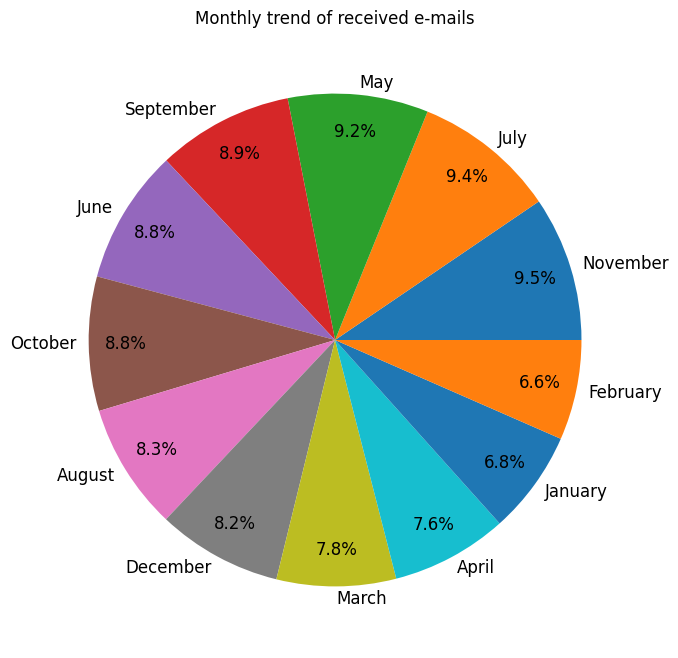

In [ ]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_inbox['Month'] = df_inbox['Date'].dt.month_name()
df_inbox['Month'] = pd.Categorical(df_inbox['Month'], categories=month_order, ordered=True)

df_inbox[:]['Month'].value_counts().plot.pie(
    figsize=(8, 8),
    title='Monthly trend of received e-mails',
    fontsize=12,
    ylabel='',
    pctdistance=0.85,
    labeldistance=1.05,
    autopct='%1.1f%%',
)
plt.show()

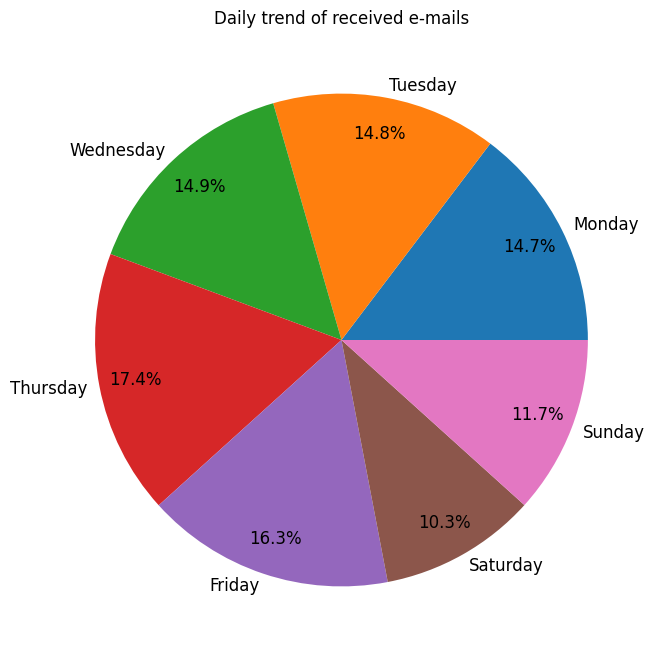

In [ ]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_inbox['Day'] = pd.Categorical(df_inbox['Day'], categories=day_order, ordered=True)

df_inbox[:]['Day'].value_counts().sort_index().plot.pie(
    figsize=(8, 8),
    title='Daily trend of received e-mails',
    fontsize=12,
    ylabel='',
    pctdistance=0.85,
    labeldistance=1.05,
    autopct='%1.1f%%',
)
plt.show()

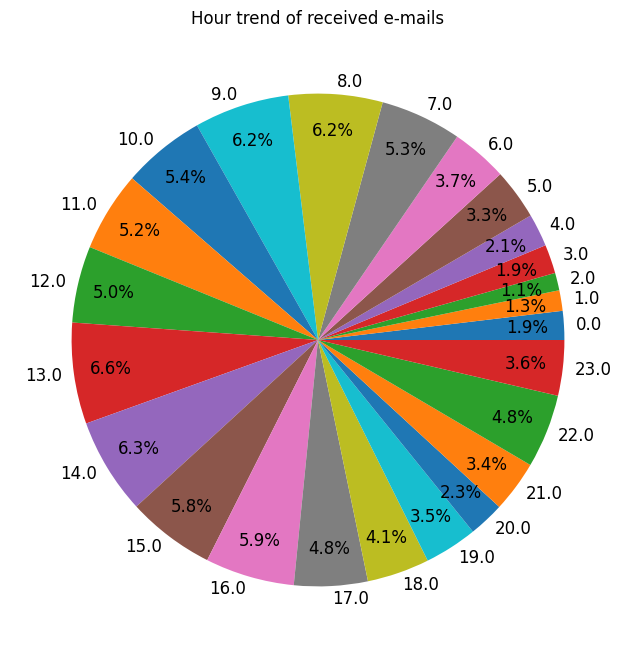

In [ ]:
hour_order = np.linspace(0, 23, 24) 
df_inbox['Hour'] = df_inbox['Date'].dt.hour
df_inbox['Hour'] = pd.Categorical(df_inbox['Hour'], categories=hour_order, ordered=True)

df_inbox[:]['Hour'].value_counts().sort_index().plot.pie(
    figsize=(8, 8),
    title='Hour trend of received e-mails',
    fontsize=12,
    ylabel='',
    pctdistance=0.85,
    labeldistance=1.05,
    autopct='%1.1f%%',
)
plt.show()

2.

In [98]:
df_sent['Only_Date'] = df_sent['Date'].dt.date
date_counts_sent = df_sent.groupby('Only_Date').size()

max_dates_sent = date_counts_sent.nlargest(5)
max_counts_sent = date_counts_sent.nlargest(5)

print("Dates with most sent e-mails:", max_dates_sent)

Dates with most sent e-mails: Only_Date
2019-06-06    4
2017-05-27    3
2017-05-31    3
2018-07-14    3
2020-03-19    3
dtype: int64


In [99]:
df_inbox['Only_Date'] = df_inbox['Date'].dt.date
date_counts_inbox = df_inbox.groupby('Only_Date').size()

max_dates_inbox = date_counts_inbox.nlargest(5)
max_counts_inbox = date_counts_inbox.nlargest(5)

print("Dates with most received e-mails:", max_dates_inbox)

Dates with most received e-mails: Only_Date
2020-05-17    48
2020-06-21    43
2020-03-30    37
2023-04-20    35
2020-05-25    29
dtype: int64


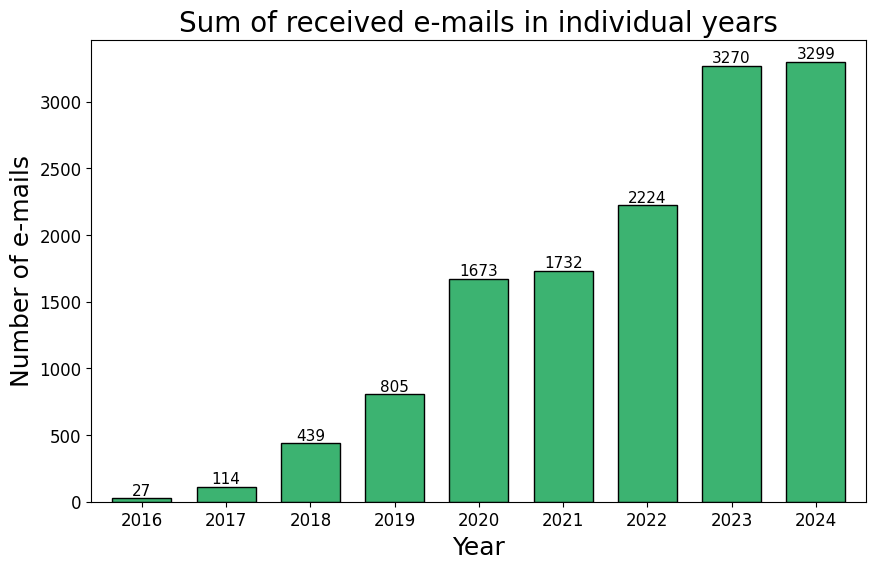

In [19]:
df_inbox['Year'] = df_inbox['Date'].dt.year
sum_of_mails_yearly = df_inbox.groupby('Year').size()
ax = sum_of_mails_yearly.plot.bar(
    figsize=(10, 6),
    edgecolor='black',
    color='mediumseagreen',
    width=0.7
)

ax.set_xticklabels(sum_of_mails_yearly.index, rotation=0, fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height():d}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)

plt.ylabel('Number of e-mails', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Sum of received e-mails in individual years', fontsize=20)
plt.show()

C:\Users\patry\AppData\Local\Temp\ipykernel_9512\661628705.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_of_mails_monthly = df_inbox.groupby('Month').size()


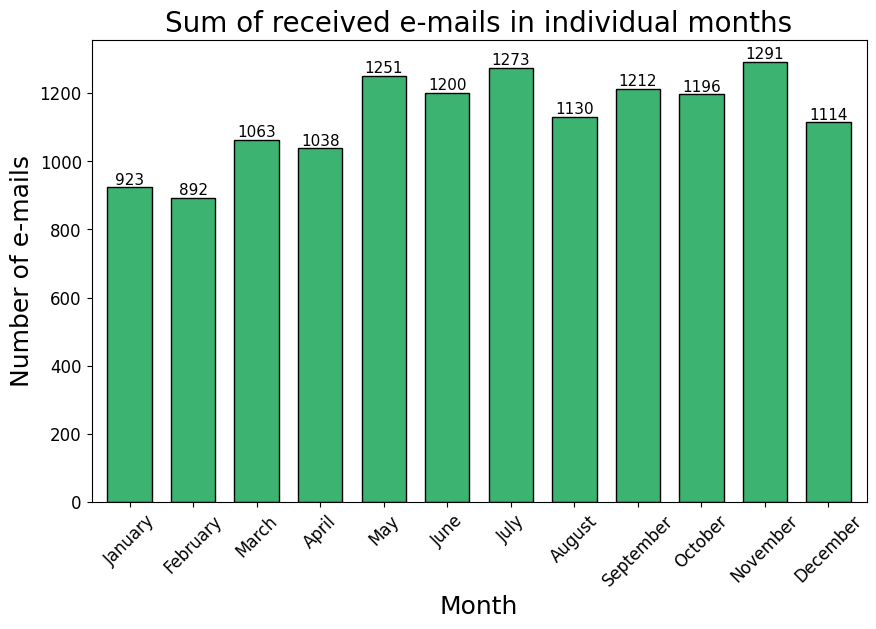

In [20]:
sum_of_mails_monthly = df_inbox.groupby('Month').size()
ax = sum_of_mails_monthly.plot.bar(
    figsize=(10, 6),
    edgecolor='black',
    color='mediumseagreen',
    width=0.7
)

ax.set_xticklabels(sum_of_mails_monthly.index, rotation=45, fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height():d}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)

plt.ylabel('Number of e-mails', fontsize=18)
plt.xlabel('Month', fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Sum of received e-mails in individual months', fontsize=20)
plt.show()

C:\Users\patry\AppData\Local\Temp\ipykernel_9512\654143639.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_of_mails_weekly = df_inbox.groupby('Day').size()


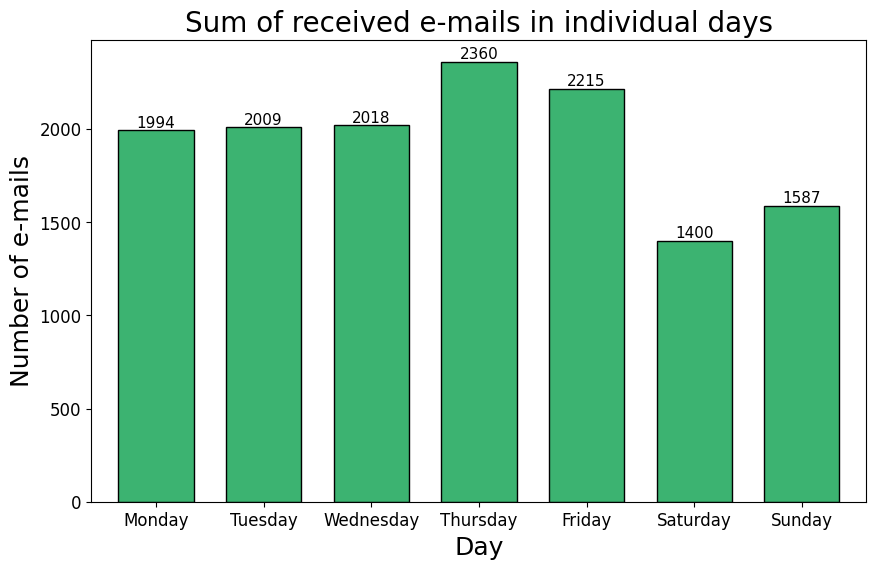

In [21]:
sum_of_mails_weekly = df_inbox.groupby('Day').size()
ax = sum_of_mails_weekly.plot.bar(
    figsize=(10, 6),
    edgecolor='black',
    color='mediumseagreen',
    width=0.7
)

ax.set_xticklabels(sum_of_mails_weekly.index, rotation=0, fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height():d}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)

plt.ylabel('Number of e-mails', fontsize=18)
plt.xlabel('Day', fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Sum of received e-mails in individual days', fontsize=20)
plt.show()

4.

In [22]:
count_receiving = df_sent[:]['To'].value_counts()[:30]
unique_receiving = df_sent['To'].value_counts().index[:30]
count_senders = df_inbox[:]['From'].value_counts()[:len(count_receiving)]
unique_senders = df_inbox['From'].value_counts().index[:len(unique_receiving)]

In [100]:
G = nx.Graph()
main = 'patrykstatkiewicz1012@gmail.com'
G.add_node(main)
G.add_nodes_from(list(unique_receiving))
for i in range(len(list(unique_senders))):
    G.add_edge(main, list(unique_receiving)[i], weight=list(count_receiving)[i])

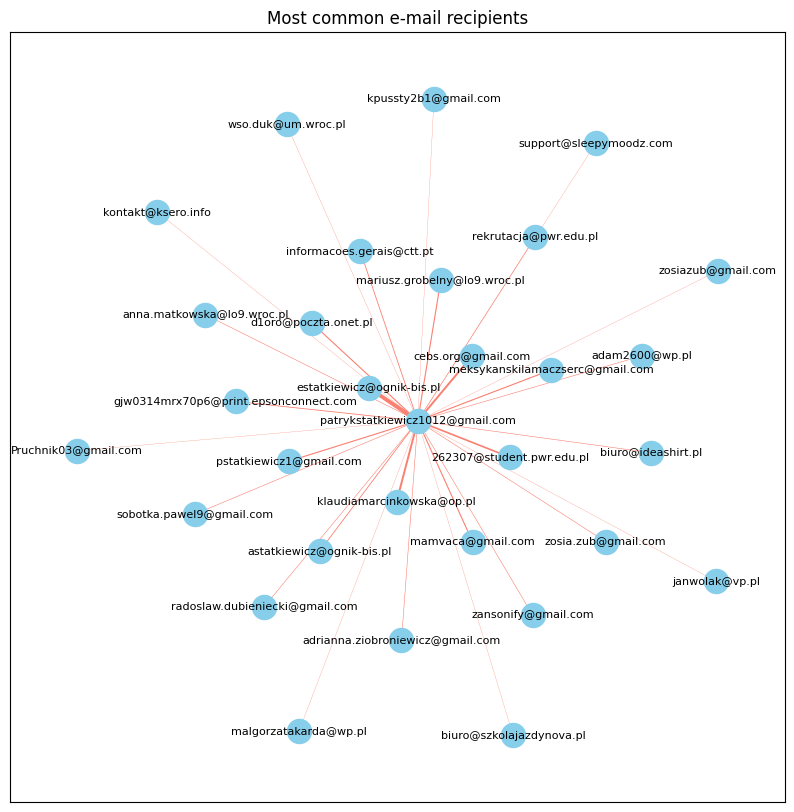

In [112]:
edge_weights = nx.get_edge_attributes(G, 'weight')
plt.figure(figsize = (10, 10))
plt.title('Most common e-mail recipients')
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
edges = nx.draw_networkx_edges(
    G, pos,
    width=[edge_weights[edge]/5 for edge in G.edges],
    edge_color='salmon',
)
plt.show()

In [113]:
G = nx.Graph()
G.add_node(main)
G.add_nodes_from(list(unique_senders))
for i in range(len(list(unique_senders))):
    G.add_edge(main, list(unique_senders)[i], weight=list(count_senders)[i])

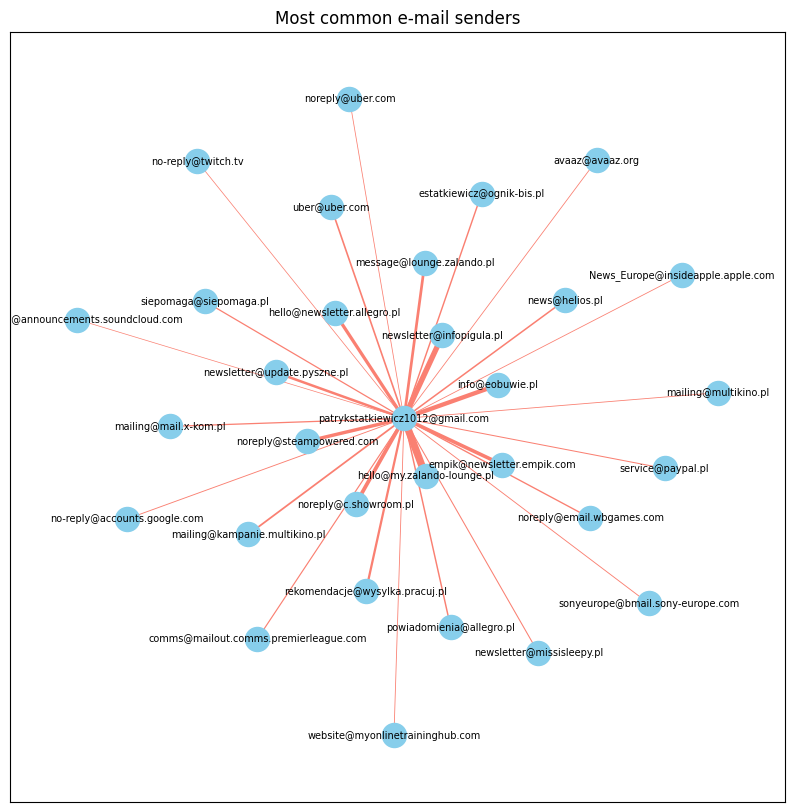

In [115]:
edge_weights = nx.get_edge_attributes(G, 'weight')
plt.figure(figsize = (10, 10))
plt.title('Most common e-mail senders')
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size= 7, font_color='black')
edges = nx.draw_networkx_edges(
    G, pos,
    width=[edge_weights[edge]/200 for edge in G.edges],
    edge_color='salmon',
)
plt.show()

5.

In [27]:
count_receiving_all = df_sent[:]['To'].value_counts()
unique_receiving_all = df_sent['To'].value_counts().index
count_senders_all = df_inbox[:]['From'].value_counts()
unique_senders_all = df_inbox['From'].value_counts().index
indices, values = [], []
for i in range(len(unique_receiving_all)):
    for j in range(len(unique_senders_all)):
        if unique_receiving_all[i] == unique_senders_all[j]:
            indices.append(unique_receiving_all[i])
            values.append(count_senders_all[j] + count_receiving_all[i])


C:\Users\patry\AppData\Local\Temp\ipykernel_9512\1618489352.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values.append(count_senders_all[j] + count_receiving_all[i])


In [116]:
G = nx.Graph()
main = 'patrykstatkiewicz1012@gmail.com'
G.add_node(main)
G.add_nodes_from(indices)
for i in range(len(indices)):
    G.add_edge(main, indices[i], weight=values[i])


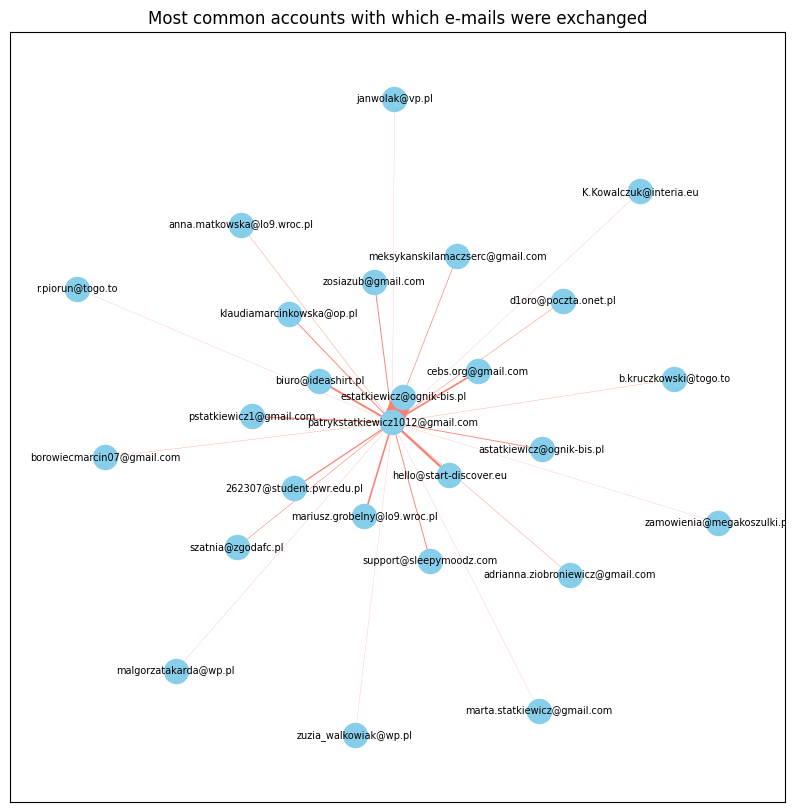

In [122]:
edge_weights = nx.get_edge_attributes(G, 'weight')
plt.figure(figsize = (10, 10))
plt.title('Most common accounts with which e-mails were exchanged')
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size= 7, font_color='black')
edges = nx.draw_networkx_edges(
    G, pos,
    width=[edge_weights[edge]/15 for edge in G.edges],
    edge_color='salmon',
)
plt.show()

6.

In [30]:
group_sizes = df_inbox.groupby(['Year', 'From']).size().reset_index(name='Count')
top_5_per_category = group_sizes.groupby('Year').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True)
top_5_per_category

C:\Users\patry\AppData\Local\Temp\ipykernel_9512\342990051.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_per_category = group_sizes.groupby('Year').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True)


,Year,From,Count
0,2016,noreply@imperiaonline.org,5
1,2016,mail-noreply@google.com,3
2,2016,no-reply@accounts.google.com,3
3,2016,noreply@battle.net,3
4,2016,patrykstatkiewiczfizyka@gmail.com,3
5,2017,noreply@em.blizzard.com,26
6,2017,noreply@youtube.com,8
7,2017,News_Europe@insideapple.apple.com,6
8,2017,no-reply@accounts.google.com,6
9,2017,wot@mail-eu.wargaming.net,6


In [31]:
unique_senders_yearly = df_inbox.groupby('Year')['From'].nunique().reset_index(name='Unique Senders')
unique_senders_yearly

,Year,Unique Senders
0,2016,12
1,2017,37
2,2018,99
3,2019,90
4,2020,156
5,2021,190
6,2022,186
7,2023,185
8,2024,187


7.

In [ ]:
def get_message_content(service, message_id):
    """
    gatting text of e-mail
    """
    message = service.users().messages().get(userId='me', id=message_id, format='full').execute()
    plain_text_content = None
    html_content = None
    payload = message['payload']
    if 'data' in payload['body']:
        plain_text_content = payload['body']['data']
    else:
        for part in payload.get('parts', []):
            if part['mimeType'] == 'text/plain' and 'data' in part['body']:
                plain_text_content = part['body']['data']
            elif part['mimeType'] == 'text/html' and 'data' in part['body']:
                html_content = part['body']['data']
    message_content = plain_text_content or html_content
    if not message_content:
        return None

    decoded_message = urlsafe_b64decode(message_content).decode('utf-8')
    
    return decoded_message

def cleaning_text(text):
    """
    cleaning text from unnecessary characters
    """
    soup = BeautifulSoup(text, 'html.parser')
    clean_text = soup.get_text(separator='\n', strip=True)
    clean_text = re.sub(r'(\r\n|\r|\n|\xa0|\u200c)', ' ', clean_text)
    clean_text = re.sub(r'\\\S+', ' ', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    clean_text = re.sub(r'\S*@\S*\s?', ' ', clean_text)
    clean_text = re.sub(r'\S*http\S*\s?', ' ', clean_text)
    clean_text = re.sub(r'\S*---\S*\s?', ' ', clean_text)

    return clean_text

def words_to_table(texts):
    """
    putting words from e-mails to one table
    """
    eng_stopwords = stopwords.words('english')
    pol_stopwords = stopwords.words('polish.txt')
    Tokenizer = RegexpTokenizer(r"[A-Za-z0-9-ąćęłńóśźż]+")
    cleaned_texts = []
    wl = WordNetLemmatizer()
    for text in texts:
        text = text.lower()
        text = Tokenizer.tokenize(text)
        text = [wl.lemmatize(word) for word in text]
        text = [word for word in text if word not in pol_stopwords]
        text = [word for word in text if word not in eng_stopwords]
        text = [word for word in text if len(word)>2]
        text = [word for word in text if not word.isnumeric()]

        cleaned_texts.append(text)

    cleaned_texts_combined = [word for sublist in cleaned_texts for word in sublist]
    
    return cleaned_texts_combined

def common_words(table, limit=10):
    """
    searching for most common words
    """
    x = Counter(table).most_common()[:limit]  
    words = [item[0] for item in x]
    occurrences = [item[1] for item in x]   
    return words, occurrences


In [38]:
texts_sent = []
length_sent = []
words_sent = []
subject_sent = []
for i in range(len(sent_messages)):
    text = get_message_content(service, sent_messages[i]['id'])
    text_ = df_sent['Subject'][i]
    if text != None:
        clean_text = cleaning_text(text)
        length_sent.append(len(clean_text))
        words_sent.append(len(clean_text.split()))
        texts_sent.append(clean_text)
    else:
        length_sent.append(0)
        words_sent.append(0)
    if text_ != None:
        clean_text_ = cleaning_text(text_)
        subject_sent.append(clean_text_)

subject_words_sent = words_to_table(subject_sent)
all_words_sent = words_to_table(texts_sent)

C:\Users\patry\AppData\Local\Temp\ipykernel_9512\3910008432.py:24: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [39]:
df_sent['Length'] = length_sent
df_sent['Words'] = words_sent
df_sent['Year'] = df_sent['Date'].dt.year

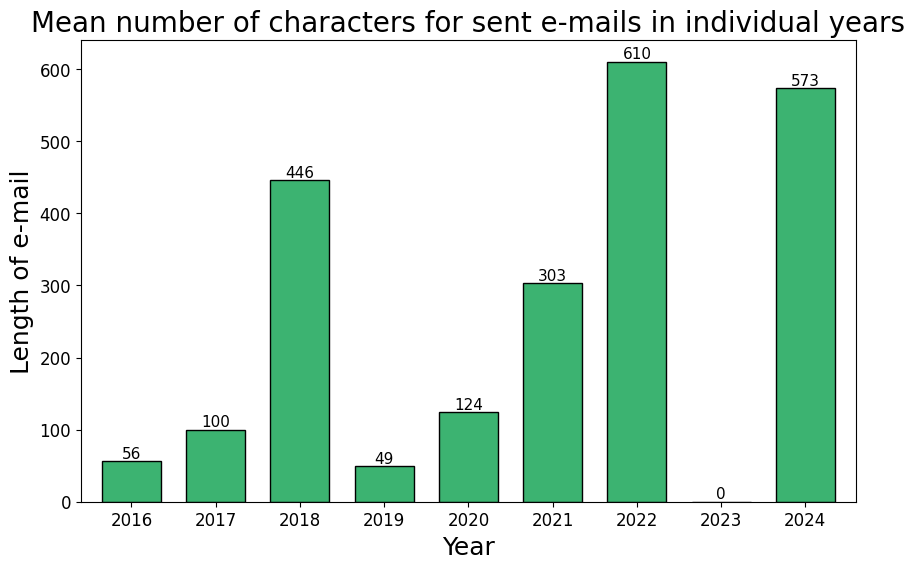

In [89]:
mean_length_of_mails_yearly_sent = df_sent.groupby('Year')['Length'].mean()
ax = mean_length_of_mails_yearly_sent.plot.bar(
    figsize=(10, 6),
    edgecolor='black',
    color='mediumseagreen',
    width=0.7
)

ax.set_xticklabels(mean_length_of_mails_yearly_sent.index, rotation=0, fontsize=12)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)

plt.ylabel('Length of e-mail', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Mean number of characters for sent e-mails in individual years', fontsize=20)
plt.show()

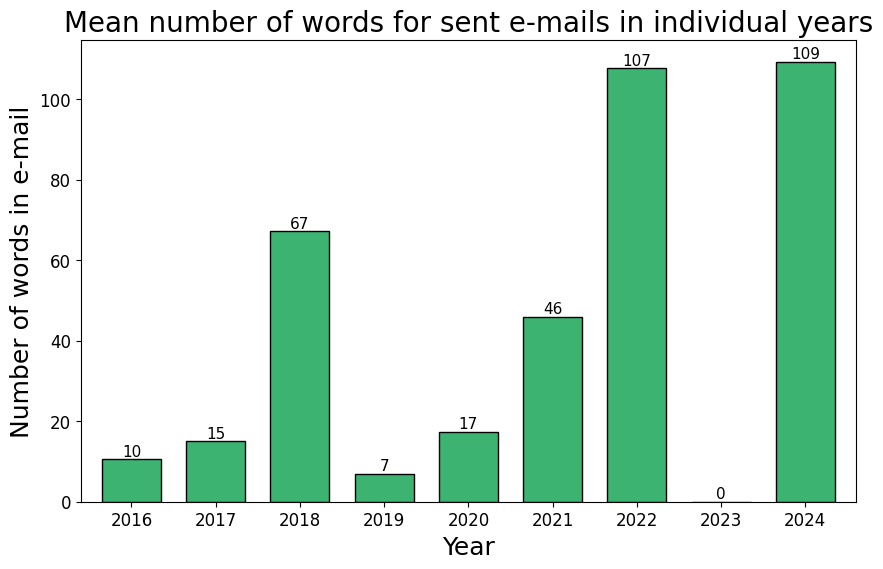

In [90]:
mean_words_of_mails_yearly_sent = df_sent.groupby('Year')['Words'].mean()
ax = mean_words_of_mails_yearly_sent.plot.bar(
    figsize=(10, 6),
    edgecolor='black',
    color='mediumseagreen',
    width=0.7
)

ax.set_xticklabels(mean_words_of_mails_yearly_sent.index, rotation=0, fontsize=12)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)

plt.ylabel('Number of words in e-mail', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Mean number of words for sent e-mails in individual years', fontsize=20)
plt.show()

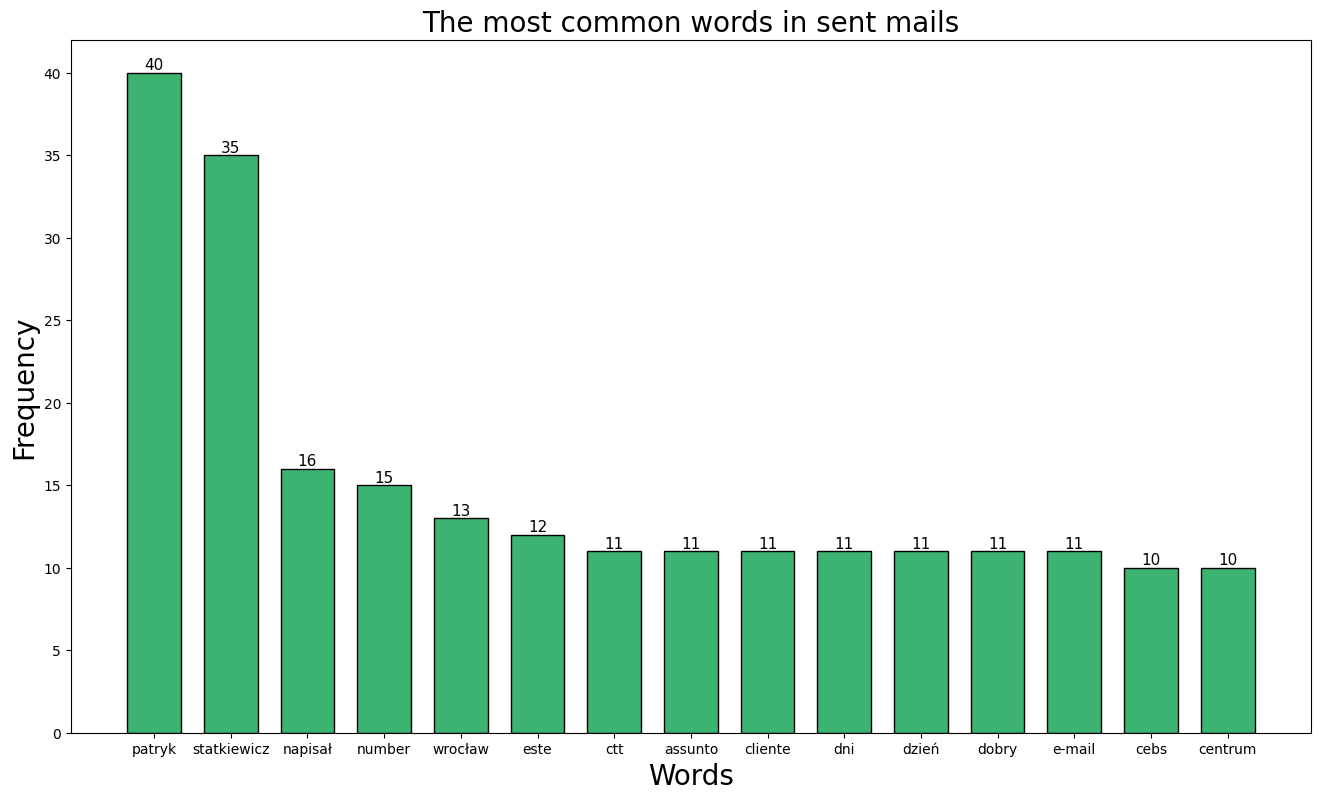

In [53]:
common_words_sent, common_occ_sent = common_words(all_words_sent, limit = 15)
fig, ax = plt.subplots(figsize=(16, 9))
plt.bar(common_words_sent, common_occ_sent, edgecolor='black', color='mediumseagreen', width=0.7)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Words', fontsize=20)
plt.title(f'The most common words in sent mails', fontsize=20)
for p in ax.patches:
    ax.annotate(f'{p.get_height():d}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)

In [47]:
texts_inbox = []
length_inbox = []
words_inbox = []
subject_inbox = []
for i in range(len(inbox_messages)):
    text = get_message_content(service, inbox_messages[i]['id'])
    text_ = df_inbox['Subject'][i]
    if text != None:
        clean_text = cleaning_text(text)
        length_inbox.append(len(clean_text))
        words_inbox.append(len(clean_text.split()))
        texts_inbox.append(clean_text)
    else:
        length_inbox.append(0)
        words_inbox.append(0)
    if text_ != None:
        clean_text_ = cleaning_text(text_)
        subject_inbox.append(clean_text_)

subject_words_inbox = words_to_table(subject_inbox)
all_words_inbox = words_to_table(texts_inbox)

C:\Users\patry\AppData\Local\Temp\ipykernel_9512\3910008432.py:24: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
C:\Users\patry\AppData\Local\Temp\ipykernel_9512\3910008432.py:24: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [48]:
df_inbox['Length'] = length_inbox
df_inbox['Words'] = words_inbox

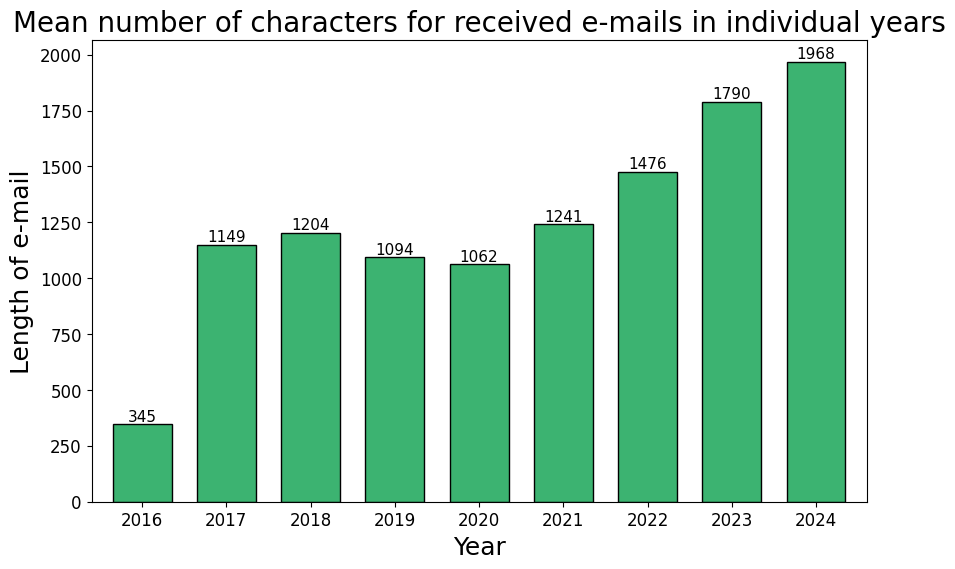

In [91]:
mean_length_of_mails_yearly_inbox = df_inbox.groupby('Year')['Length'].mean()
ax = mean_length_of_mails_yearly_inbox.plot.bar(
    figsize=(10, 6),
    edgecolor='black',
    color='mediumseagreen',
    width=0.7
)

ax.set_xticklabels(mean_length_of_mails_yearly_inbox.index, rotation=0, fontsize=12)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)

plt.ylabel('Length of e-mail', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Mean number of characters for received e-mails in individual years', fontsize=20)
plt.show()

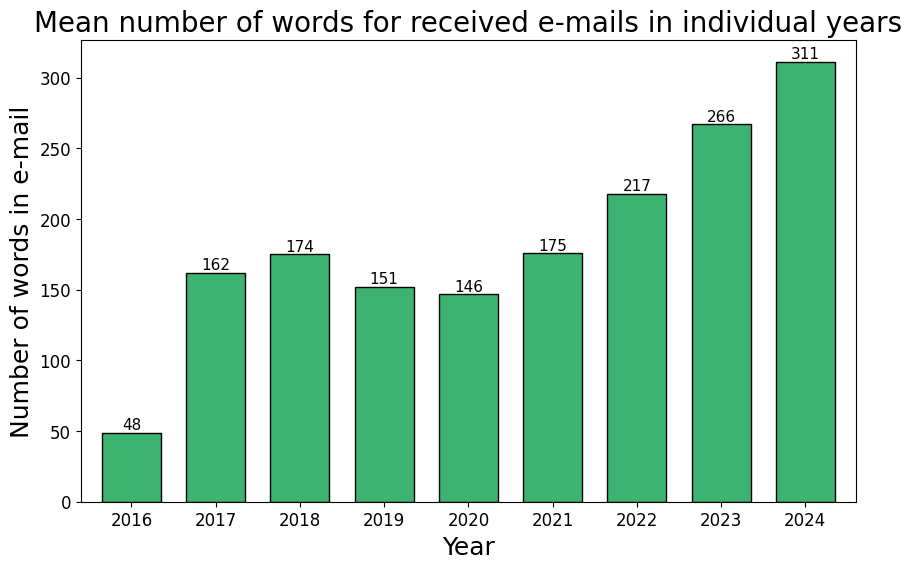

In [92]:
mean_words_of_mails_yearly_inbox = df_inbox.groupby('Year')['Words'].mean()
ax = mean_words_of_mails_yearly_inbox.plot.bar(
    figsize=(10, 6),
    edgecolor='black',
    color='mediumseagreen',
    width=0.7
)

ax.set_xticklabels(mean_words_of_mails_yearly_inbox.index, rotation=0, fontsize=12)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)

plt.ylabel('Number of words in e-mail', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Mean number of words for received e-mails in individual years', fontsize=20)
plt.show()

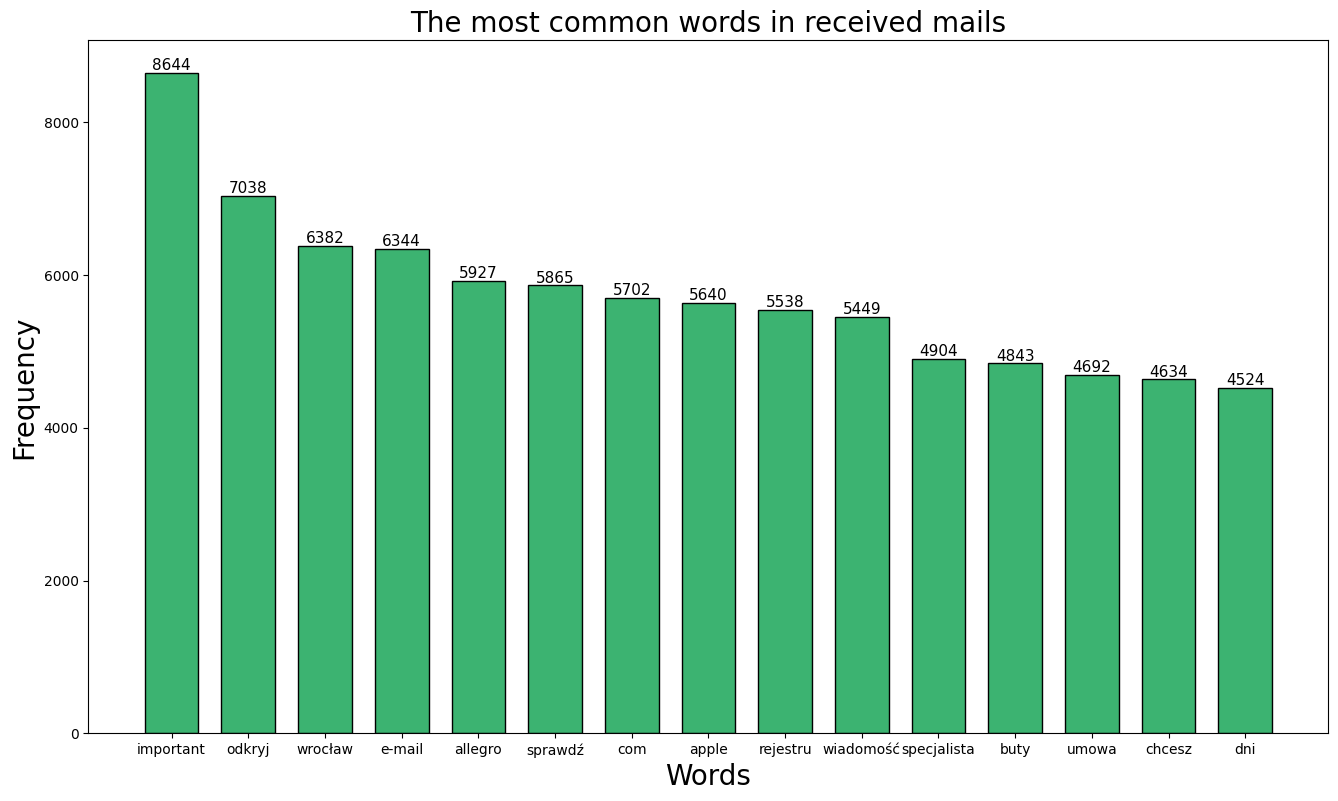

In [56]:
common_words_inbox, common_occ_inbox = common_words(all_words_inbox, limit = 15)
fig, ax = plt.subplots(figsize = (16, 9))
plt.bar(common_words_inbox, common_occ_inbox, edgecolor='black', color='mediumseagreen', width=0.7)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Words', fontsize=20)
plt.title(f'The most common words in received mails', fontsize=20)
for p in ax.patches:
    ax.annotate(f'{p.get_height():d}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)

8.

In [ ]:
def find_original_email(service, message_id, df1 = df_sent, df2 = df_inbox):
    """
    finding original e-mail for all reply e-mails  
    """
    message = service.users().messages().get(userId='me', id=message_id, format='full').execute()
    
    headers = message['payload'].get('headers', [])
    in_reply_to = None
    for header in headers:
        if header['name'] == 'In-Reply-To':
            in_reply_to = header['value']
            break

    query = f"rfc822msgid:{in_reply_to}"
    search_result = service.users().messages().list(userId='me', q=query).execute()
    if 'messages' in search_result:
        mail = []
        original_message_id = search_result['messages'][0]['id']
        try:
            df1.index[df1['Message_ID'] == original_message_id][0]
            original = df1.index[df1['Message_ID'] == original_message_id]
            mail.append('df_sent')
        except IndexError:
            original = df2.index[df2['Message_ID'] == original_message_id]
            mail.append('df_inbox')
        reply = df1.index[df1['Message_ID'] == message_id]
        mail.extend([original[0], reply[0]])
        return mail


In [58]:
df_replies = pd.DataFrame(columns=['Time of response', 'Reply send at', 'Email send by', 'At'])

for i in range(len(sent_messages)):
    mail_info = find_original_email(service, sent_messages[i]['id'])
    if mail_info != None:
        if mail_info[0] == 'df_sent':
            diff = df_sent['Date'][mail_info[2]] - df_sent['Date'][mail_info[1]]
            df_replies.loc[i] = [diff] + [str(df_sent['Day'][mail_info[2]]) + ', ' + str(df_sent['Date'][mail_info[2]])] + \
                [df_sent['From'][mail_info[1]]] + [str(df_sent['Day'][mail_info[1]]) + ', ' + str(df_sent['Date'][mail_info[1]])]
        else:
            diff = df_sent['Date'][mail_info[2]] - df_inbox['Date'][mail_info[1]]
            df_replies.loc[i] = [diff] + [str(df_sent['Day'][mail_info[2]]) + ', ' + str(df_sent['Date'][mail_info[2]])] + \
                [df_inbox['From'][mail_info[1]]] + [str(df_inbox['Day'][mail_info[1]]) + ', ' + str(df_inbox['Date'][mail_info[1]])]

df_replies
#print(df_replies.to_string(index=False))  

,Time of response,Reply send at,Email send by,At
4,0 days 00:13:10,"Wednesday, 2024-07-31 23:16:15",patrykstatkiewicz1012@gmail.com,"Wednesday, 2024-07-31 23:03:05"
5,0 days 02:06:44,"Wednesday, 2024-07-31 23:03:05",CTT@crm.ctt.pt,"Wednesday, 2024-07-31 20:56:21"
6,0 days 02:02:06,"Wednesday, 2024-07-31 00:58:33",CTT@crm.ctt.pt,"Tuesday, 2024-07-30 22:56:27"
13,0 days 15:49:38,"Wednesday, 2022-10-12 08:33:21",262307@student.pwr.edu.pl,"Tuesday, 2022-10-11 16:43:43"
16,0 days 00:01:37,"Wednesday, 2022-09-21 13:57:10",cebs.org@gmail.com,"Wednesday, 2022-09-21 13:55:33"
17,0 days 22:26:37,"Wednesday, 2022-09-21 11:56:58",cebs.org@gmail.com,"Tuesday, 2022-09-20 13:30:21"
18,0 days 00:16:59,"Tuesday, 2022-09-20 10:29:18",patrykstatkiewicz1012@gmail.com,"Tuesday, 2022-09-20 10:12:19"
19,0 days 19:42:10,"Tuesday, 2022-09-20 10:12:19",cebs.org@gmail.com,"Monday, 2022-09-19 14:30:09"
20,0 days 19:38:24,"Tuesday, 2022-09-20 10:08:33",cebs.org@gmail.com,"Monday, 2022-09-19 14:30:09"
21,0 days 00:16:56,"Friday, 2022-08-05 23:40:42",cebs.org@gmail.com,"Friday, 2022-08-05 23:23:46"


In [59]:
print('Average time of response:', df_replies['Time of response'].mean())
print('Median of response times:', df_replies['Time of response'].median())

Average time of response: 1 days 03:40:45.040000
Median of response times: 0 days 02:02:06


9.

In [ ]:
def get_attachment_extensions(message):
    """
    taking all extensions fromm e-mails
    """
    extensions = [] 
    if 'parts' in message['payload']:
        for part in message['payload']['parts']:
            filename = part.get('filename')
            if filename:
                match = re.search(r'\.([^.]+)$', filename.lower())
                if match:
                    extensions.append(match.group(1))

    return extensions

def count_extentions(messages):
    """
    counting e-mails with each type of extension
    """
    attachments = []
    number_of_extentions = []
    for i in range(len(messages)):
        message = service.users().messages().get(userId='me', id=messages[i]['id']).execute()
        attachment_extensions = get_attachment_extensions(message)
        for j in range(len(attachment_extensions)):
            if attachment_extensions[j] not in attachments:
                attachments.append(attachment_extensions[j])
                number_of_extentions.append(1)
            else:
                for k in range(len(attachments)):
                    if attachment_extensions[j] == attachments[k]:
                        number_of_extentions[k] += 1
    return attachments, number_of_extentions



In [61]:
attachments_sent, number_of_extentions_sent = count_extentions(sent_messages)
df_extensions_sent = pd.DataFrame({'Number of files': number_of_extentions_sent}, index = attachments_sent)
#df_extensions_sent

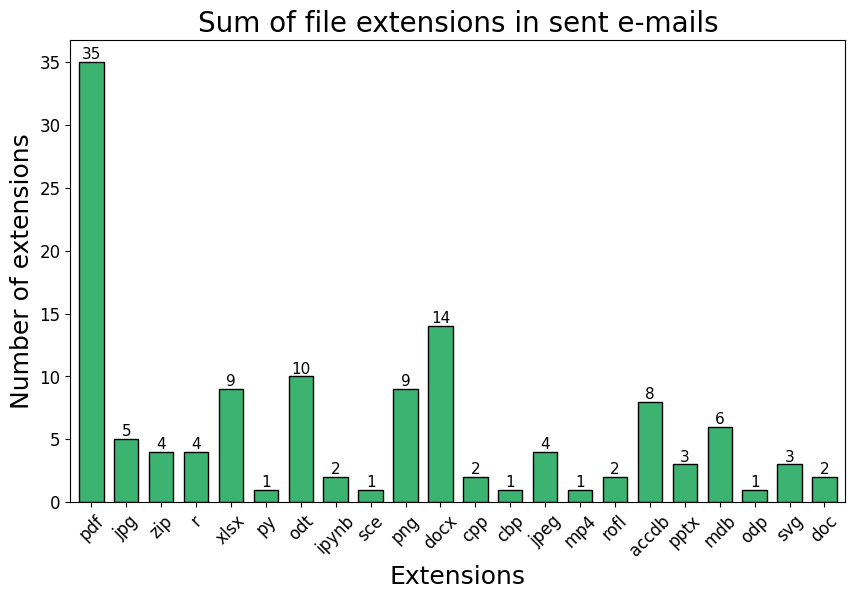

In [62]:
ax = df_extensions_sent.plot.bar(
    figsize=(10, 6),
    edgecolor='black',
    color='mediumseagreen',
    width=0.7
)

ax.set_xticklabels(df_extensions_sent.index, rotation=45, fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height():d}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)

plt.ylabel('Number of extensions', fontsize=18)
plt.xlabel('Extensions', fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Sum of file extensions in sent e-mails', fontsize=20)
plt.legend().remove()
plt.show()

In [63]:
attachments_inbox, number_of_extentions_inbox = count_extentions(inbox_messages)
df_extensions_inbox = pd.DataFrame({'Number of files': number_of_extentions_inbox}, index = attachments_inbox)
#df_extensions_inbox

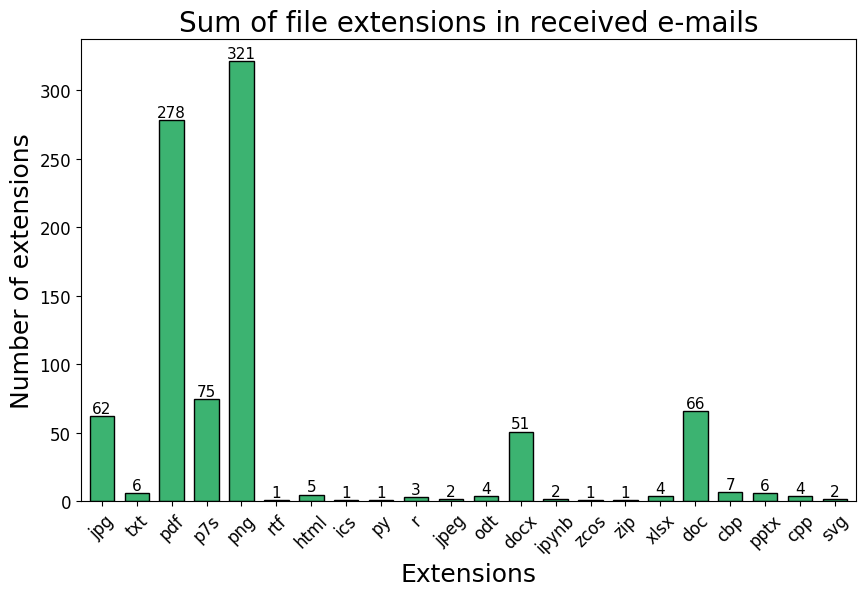

In [64]:
ax = df_extensions_inbox.plot.bar(
    figsize=(10, 6),
    edgecolor='black',
    color='mediumseagreen',
    width=0.7
)

ax.set_xticklabels(df_extensions_inbox.index, rotation=45, fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height():d}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)

plt.ylabel('Number of extensions', fontsize=18)
plt.xlabel('Extensions', fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Sum of file extensions in received e-mails', fontsize=20)
plt.legend().remove()
plt.show()

10.

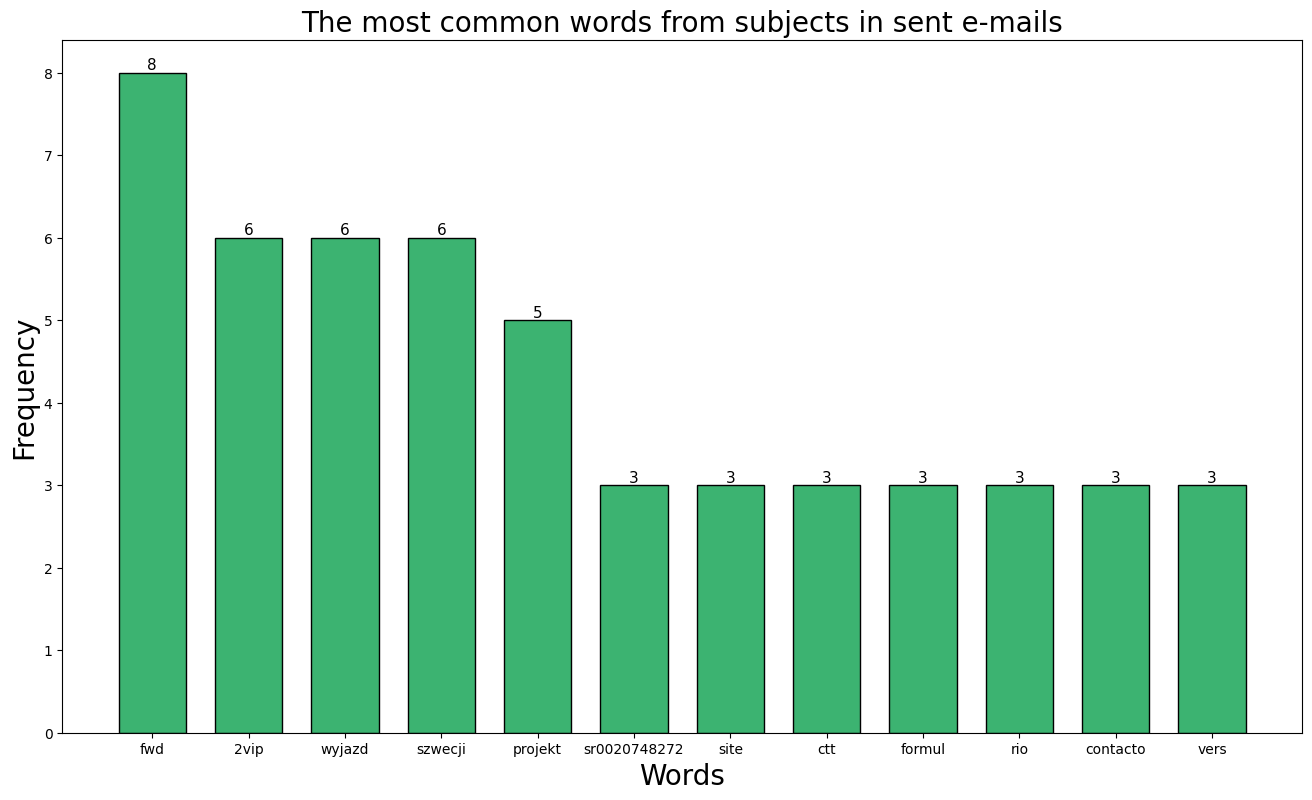

In [93]:
subject_common_words_sent, subject_common_occ_sent = common_words(subject_words_sent, limit = 12)
fig, ax = plt.subplots(figsize = (16, 9))
plt.bar(subject_common_words_sent, subject_common_occ_sent, edgecolor='black', color='mediumseagreen', width=0.7)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Words', fontsize=20)
plt.title(f'The most common words from subjects in sent e-mails', fontsize=20)
for p in ax.patches:
    ax.annotate(f'{p.get_height():d}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)

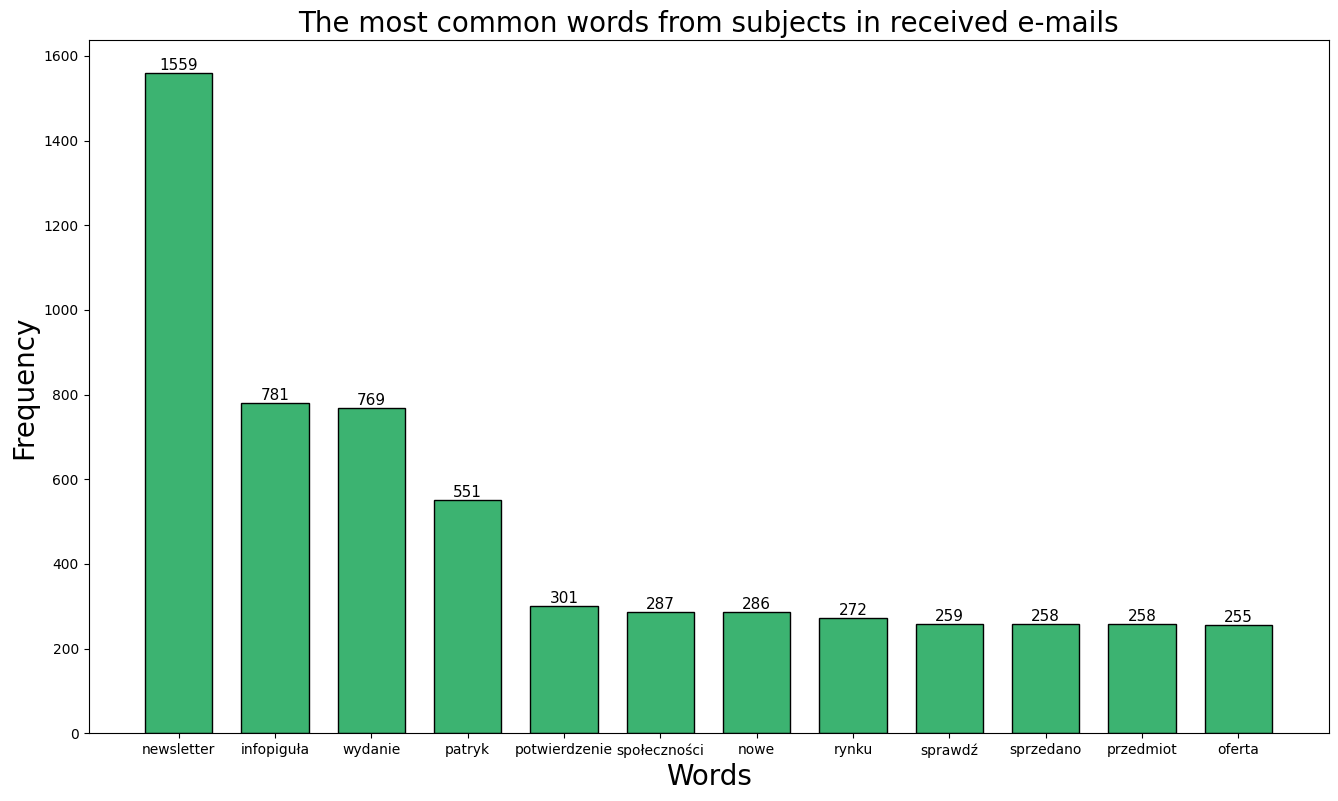

In [94]:
subject_common_words_inbox, subject_common_occ_inbox = common_words(subject_words_inbox, limit = 12)
fig, ax = plt.subplots(figsize = (16, 9))
plt.bar(subject_common_words_inbox, subject_common_occ_inbox, edgecolor='black', color='mediumseagreen', width=0.7)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Words', fontsize=20)
plt.title(f'The most common words from subjects in received e-mails', fontsize=20)
for p in ax.patches:
    ax.annotate(f'{p.get_height():d}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=11)